In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [2]:
import nltk
import regex as re
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [3]:
data = pd.read_csv('final_new_data_processed.csv')
print(data.shape)
data.head(3)

(212098, 58)


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_sentiment,cleaned_review,sentiment_score,...,10,11,12,13,14,15,16,17,18,19
0,206461,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,1,no side effect take combin bystol mg fish oil,-0.2960,...,0.007515,0.007186,0.017940,0.008827,0.009740,0.010562,0.006819,0.429381,0.013676,0.077992
1,95260,guanfacine,adhd,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,1,son halfway fourth week intuniv becam concern ...,0.8603,...,0.003576,0.003419,0.008536,0.004200,0.004634,0.005026,0.003245,0.494278,0.006508,0.074561
2,92703,lybrel,birth control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,0,use take anoth oral contracept pill cycl happi...,0.7962,...,0.022085,0.003387,0.008456,0.004161,0.115890,0.004978,0.003214,0.363426,0.006446,0.055310


### Splitting the data to Train and Test

In [4]:
X = data.drop(['uniqueID','review','rating','date','review_sentiment'],axis=1)
y = data['review_sentiment'].values
print(X.shape)
X.head(3)

(212098, 53)


,drugName,condition,usefulCount,cleaned_review,sentiment_score,sentiment_score_clean,year,word_count,unique_word_count,char_length,...,10,11,12,13,14,15,16,17,18,19
0,valsartan,left ventricular dysfunction,27,no side effect take combin bystol mg fish oil,-0.2960,-0.2960,2012,9,9,46,...,0.007515,0.007186,0.017940,0.008827,0.009740,0.010562,0.006819,0.429381,0.013676,0.077992
1,guanfacine,adhd,192,son halfway fourth week intuniv becam concern ...,0.8603,0.6929,2010,65,54,372,...,0.003576,0.003419,0.008536,0.004200,0.004634,0.005026,0.003245,0.494278,0.006508,0.074561
2,lybrel,birth control,17,use take anoth oral contracept pill cycl happi...,0.7962,0.2732,2009,70,49,403,...,0.022085,0.003387,0.008456,0.004161,0.115890,0.004978,0.003214,0.363426,0.006446,0.055310


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.30,random_state=42)

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.30,random_state=42)

In [6]:
print('Train data size is:',X_train.shape)
print('Cross Validation data size is:',X_cv.shape)
print('Test data size is:',X_test.shape)

Train data size is: (103927, 53)
Cross Validation data size is: (44541, 53)
Test data size is: (63630, 53)


### Encoding Categorical,Text.Numerical features

Label Encoding the condition and Year feature 

In [7]:
from sklearn.preprocessing import LabelEncoder

lab_enc_cond = LabelEncoder()

lab_enc_cond.fit(X['condition'].values)

X_train_condition = lab_enc_cond.transform(X_train['condition'].values).reshape(-1,1)
X_test_condition = lab_enc_cond.transform(X_test['condition'].values).reshape(-1,1)
X_cv_condition = lab_enc_cond.transform(X_cv['condition'].values).reshape(-1,1)

print('After Encoding')
print('Train data shape',X_train_condition.shape)
print('Test data shape',X_test_condition.shape)
print('CV data shape',X_cv_condition.shape)

After Encoding
Train data shape (103927, 1)
Test data shape (63630, 1)
CV data shape (44541, 1)


In [9]:
import joblib
print('Saving condition encoder..')
joblib.dump(lab_enc_cond,'condition_encoder.pkl')

Saving condition encoder..


['condition_encoder.pkl']

In [8]:

lab_enc_year = LabelEncoder()

lab_enc_year.fit(X['year'].values)

X_train_year = lab_enc_year.transform(X_train['year'].values).reshape(-1,1)
X_test_year = lab_enc_year.transform(X_test['year'].values).reshape(-1,1)
X_cv_year = lab_enc_year.transform(X_cv['year'].values).reshape(-1,1)

print('After Encoding')
print('Train data shape',X_train_year.shape)
print('Test data shape',X_test_year.shape)
print('CV data shape',X_cv_year.shape)

After Encoding
Train data shape (103927, 1)
Test data shape (63630, 1)
CV data shape (44541, 1)


In [11]:
print('Saving year encoder..')
joblib.dump(lab_enc_year,'year_encoder.pkl')

Saving year encoder..


['year_encoder.pkl']

<b>Vectorizing the Cleaned reviews using BoW (1 grams)</b>

In [9]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
import joblib

In [10]:
vect_bow_1 = CountVectorizer(min_df=10,ngram_range=(1,1))

vect_bow_1.fit(X_train['cleaned_review'].values) # fitted on train data only

X_train_review_bow_1 = vect_bow_1.transform(X_train['cleaned_review'].values)
X_test_review_bow_1 = vect_bow_1.transform(X_test['cleaned_review'].values)
X_cv_review_bow_1 = vect_bow_1.transform(X_cv['cleaned_review'].values)

print('After Vectorization')
print('Train data shape:',X_train_review_bow_1.shape)
print('Test data shape:',X_test_review_bow_1.shape)
print('CV data shape:',X_cv_review_bow_1.shape)

After Vectorization
Train data shape: (103927, 7309)
Test data shape: (63630, 7309)
CV data shape: (44541, 7309)


In [11]:
print('Vectorizer for BoW is saved..')
joblib.dump(vect_bow_1,'vectorizer_bow.pkl')

Vectorizer for BoW is saved..


['vectorizer_bow.pkl']

In [10]:
vect_bow_1 = joblib.load('vectorizer_bow.pkl')

X_train_review_bow_1 = vect_bow_1.transform(X_train['cleaned_review'].values)
X_test_review_bow_1 = vect_bow_1.transform(X_test['cleaned_review'].values)
X_cv_review_bow_1 = vect_bow_1.transform(X_cv['cleaned_review'].values)

print('After Vectorization')
print('Train data shape:',X_train_review_bow_1.shape)
print('Test data shape:',X_test_review_bow_1.shape)
print('CV data shape:',X_cv_review_bow_1.shape)


After Vectorization
Train data shape: (103927, 7309)
Test data shape: (63630, 7309)
CV data shape: (44541, 7309)


<b>Vectorizing the Cleaned reviews using TF-IDF (1 grams)</b>

In [15]:
vect_tfidf_1 = TfidfVectorizer(min_df=10,ngram_range=(1,1))

vect_tfidf_1.fit(X_train['cleaned_review'].values) # fitted on train data only

X_train_review_tfidf_1 = vect_tfidf_1.transform(X_train['cleaned_review'].values)
X_test_review_tfidf_1 = vect_tfidf_1.transform(X_test['cleaned_review'].values)
X_cv_review_tfidf_1 = vect_tfidf_1.transform(X_cv['cleaned_review'].values)

print('After Vectorization')
print('Train data shape:',X_train_review_tfidf_1.shape)
print('Test data shape:',X_test_review_tfidf_1.shape)
print('CV data shape:',X_cv_review_tfidf_1.shape)

After Vectorization
Train data shape: (103927, 7309)
Test data shape: (63630, 7309)
CV data shape: (44541, 7309)


In [16]:
print('Vectorizer for TF-IDF is saved..')
joblib.dump(vect_tfidf_1,'vectorizer_tfidf.pkl')

Vectorizer for TF-IDF is saved..


['vectorizer_tfidf.pkl']

In [11]:
vect_tfidf_1 = joblib.load('vectorizer_tfidf.pkl')


X_train_review_tfidf_1 = vect_tfidf_1.transform(X_train['cleaned_review'].values)
X_test_review_tfidf_1 = vect_tfidf_1.transform(X_test['cleaned_review'].values)
X_cv_review_tfidf_1 = vect_tfidf_1.transform(X_cv['cleaned_review'].values)

print('After Vectorization')
print('Train data shape:',X_train_review_tfidf_1.shape)
print('Test data shape:',X_test_review_tfidf_1.shape)
print('CV data shape:',X_cv_review_tfidf_1.shape)

After Vectorization
Train data shape: (103927, 7309)
Test data shape: (63630, 7309)
CV data shape: (44541, 7309)


<b> Word2Vec Vectorization for reviews using pretrained glove model

In [22]:
from tqdm import tqdm
cleaned_reviews = data['cleaned_review'].values

In [23]:
#Reading glove vectors

def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.6B.300d.txt')


words = []
for i in cleaned_reviews:
    words.extend(i.split(' '))

print("all the words in the corpus", len(words))
words = set(words)
print("the unique words in the corpus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our corpus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


Loading Glove Model


400000it [00:37, 10759.70it/s]


Done. 400000  words loaded!
all the words in the corpus 8868694
the unique words in the corpus 34667
The number of words that are present in both glove vectors and our corpus 13620 ( 39.288 %)
word 2 vec length 13620


In [24]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
print(len(glove_words))

13620


- Only 13260 (39%) of words in corpus are present in glove vectors. Very few words of corpus might have a 300 dim vector representation. Rest of the words are represented as zeros.Hence considering only bow and tfidf representation

<b>Normalizing the Numerical features</b>

In [14]:
columns = ['usefulCount','word_count','unique_word_count','char_length','count_punctuations','stopword_count',
               'mean_word_len','subj_count','obj_count','CARDINAL','DATE','EVENT','FAC','GPE','LANGUAGE','LAW',
            'LOC','MONEY','NORP','ORDINAL','ORG', 'PERCENT','PERSON', 'PRODUCT','QUANTITY','TIME','WORK_OF_ART',
           '0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']

In [15]:
normalizer = Normalizer()

X_train_num_1 = normalizer.fit_transform(X_train[columns])
X_test_num_1 = normalizer.fit_transform(X_test[columns])
X_cv_num_1 = normalizer.fit_transform(X_cv[columns])

print("After vectorizations")
print(X_train_num_1.shape, y_train.shape)
print(X_test_num_1.shape, y_test.shape)
print(X_cv_num_1.shape, y_cv.shape)



After vectorizations
(103927, 47) (103927,)
(63630, 47) (63630,)
(44541, 47) (44541,)


In [12]:
X_train_sent_score = X_train[['sentiment_score','sentiment_score_clean']].values
X_test_sent_score = X_test[['sentiment_score','sentiment_score_clean']].values
X_cv_sent_score = X_cv[['sentiment_score','sentiment_score_clean']].values

print("After vectorizations")
print(X_train_sent_score.shape, y_train.shape)
print(X_test_sent_score.shape, y_test.shape)
print(X_cv_sent_score.shape, y_cv.shape)

After vectorizations
(103927, 2) (103927,)
(63630, 2) (63630,)
(44541, 2) (44541,)


<b>Next steps:</b>
<br>
Train the model with different set of features like:
- Train the models with BoW vectorized features (try 1,2,3,4 n grams)
- Train the models with TF-IDF vectorized features (try 1,2,3,4 n grams)
- Train the model with only review extracted features
</br>

<br>
Pick the best model and evaluate the recommendation score for each drug
</br>

### Set-1: All  Extracted Features + Sentiment scores 

In [16]:
#concatenating all encoded features for set 1 

from scipy.sparse import hstack
X_tr_1 = np.concatenate((X_train_num_1,X_train_sent_score),axis=1)

X_te_1 = np.concatenate((X_test_num_1,X_test_sent_score),axis=1)

X_cv_1 = np.concatenate((X_cv_num_1,X_cv_sent_score),axis=1)

print("Final Data matrix")
print(X_tr_1.shape, y_train.shape)
print(X_te_1.shape, y_test.shape)
print(X_cv_1.shape, y_cv.shape)

Final Data matrix
(103927, 49) (103927,)
(63630, 49) (63630,)
(44541, 49) (44541,)


## Modelling 

In [17]:
from sklearn.metrics import log_loss, accuracy_score,confusion_matrix, f1_score,roc_auc_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
import joblib

In [18]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [19]:
def model_metrics(clf,train_data,test_data,cv_data):
    
    print('**LogLoss**')
    predict_y = clf.predict_proba(train_data)
    print ("The train log loss is:",log_loss(y_train, predict_y))
    predict_y = clf.predict_proba(cv_data)
    print( "The cross validation log loss is:",log_loss(y_cv, predict_y))
    predict_y = clf.predict_proba(test_data)
    print( "The test log loss is:",log_loss(y_test, predict_y))

    print(50*'-')
    
    print('**Accuracy**')
    y_pred_tr = clf.predict(train_data)
    print ("The train Accuracy is:",accuracy_score(y_train, y_pred_tr))
    y_pred_cv = clf.predict(cv_data)
    print( "The cross validation Accuracy is:",accuracy_score(y_cv, y_pred_cv))
    y_pred_te = clf.predict(test_data)
    print( "The test Accuracy is:",accuracy_score(y_test, y_pred_te))

    print(50*'-')

     
    print('**F1 Score**')    
    print ("The train F1 score is:",f1_score(y_train, y_pred_tr))
    print( "The cross validation F1 score is:",f1_score(y_cv, y_pred_cv))
    print( "The test F1 score is:",f1_score(y_test, y_pred_te))

    print(50*'-')

    print('**AUC**')   
    print ("The train AUC is:",roc_auc_score(y_train, y_pred_tr))
    print( "The cross validation AUC is:",roc_auc_score(y_cv, y_pred_cv))
    print( "The test AUC is:",roc_auc_score(y_test, y_pred_te))

    print(50*'-')

### Random Model

In [27]:
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)

print("Accuray on Test Data using Random Model",accuracy_score(y_test, predicted_y))
print("F1 score on Test Data using Random Model",f1_score(y_test, predicted_y))
print("AUC on Test Data using Random Model",roc_auc_score(y_test, predicted_y))


Log loss on Test Data using Random Model 0.8884656898614192
Accuray on Test Data using Random Model 0.4974225994027974
F1 score on Test Data using Random Model 0.5813554662442563
AUC on Test Data using Random Model 0.4971595075043844


Number of misclassified points  50.257740059720255


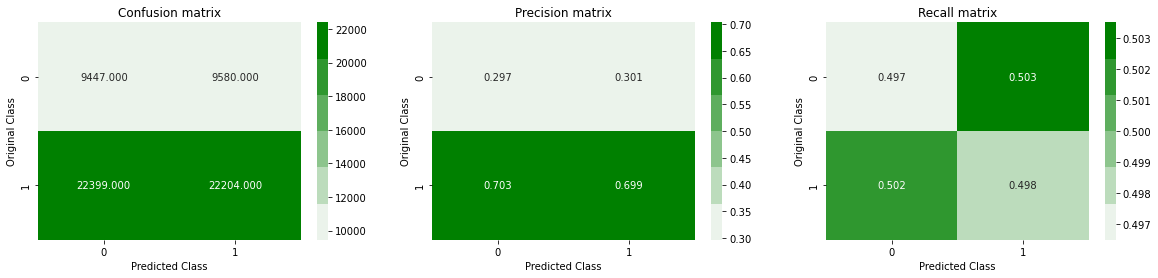

In [28]:
plot_confusion_matrix(y_test,predicted_y)

Observation:
- The Random model shows that the worst case log loss,F1 score, Accuracy and AUC. 

### K Nearest Neighbour Classification 

In [29]:
param ={'n_neighbors': [x for x in range(1, 15, 2)]}

k_cfl = KNeighborsClassifier()

random_kcfl = RandomizedSearchCV(k_cfl,param_distributions=param,scoring='f1',verbose=1,n_jobs=-1,cv=3)
random_kcfl.fit(X_tr_1,y_train)

print(random_kcfl.best_params_)


Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'n_neighbors': 13}


**LogLoss**
The train log loss is: 0.49597387313835994
The cross validation log loss is: 0.5339671860279693
The test log loss is: 0.534741347524283
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.7567619579127657
The cross validation Accuracy is: 0.7316854134393032
The test Accuracy is: 0.7293886531510294
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.8435230979690624
The cross validation F1 score is: 0.8275742667109117
The test F1 score is: 0.8261040810349529
--------------------------------------------------
**AUC**
The train AUC is: 0.6367751191964683
The cross validation AUC is: 0.6060743167074485
The test AUC is: 0.6033098574930744
--------------------------------------------------
Number of misclassified points  27.06113468489706


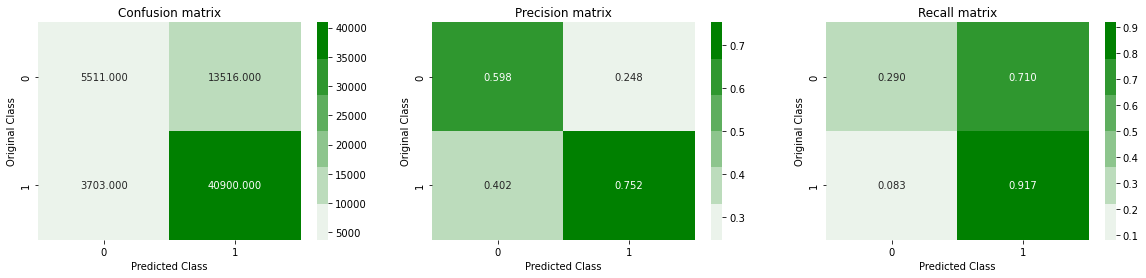

In [30]:
k_cfl=KNeighborsClassifier(n_neighbors=13,n_jobs=-1)
k_cfl.fit(X_tr_1,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_tr_1, y_train)
    
model_metrics(sig_clf,X_tr_1,X_te_1,X_cv_1)

plot_confusion_matrix(y_test, sig_clf.predict(X_te_1))


### Logistic Regression

In [54]:
param = {'C':[10 ** x for x in range(-5, 4)]}

logisticR=LogisticRegression(penalty='l2',class_weight='balanced')

random_lr = RandomizedSearchCV(logisticR,param_distributions=param,scoring='f1',verbose=1,n_jobs=-1,cv=3)
random_lr.fit(X_tr_1,y_train)

print(random_lr.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'C': 100}


**LogLoss**
The train log loss is: 0.5356943056166035
The cross validation log loss is: 0.534834613547921
The test log loss is: 0.5361495438174686
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.7331203633319542
The cross validation Accuracy is: 0.7348959385734491
The test Accuracy is: 0.7325003928964325
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.8254345883211862
The cross validation F1 score is: 0.8266842800528401
The test F1 score is: 0.8250829830745358
--------------------------------------------------
**AUC**
The train AUC is: 0.6208708738055619
The cross validation AUC is: 0.6226145852451497
The test AUC is: 0.6199047291047557
--------------------------------------------------
Number of misclassified points  26.749960710356753


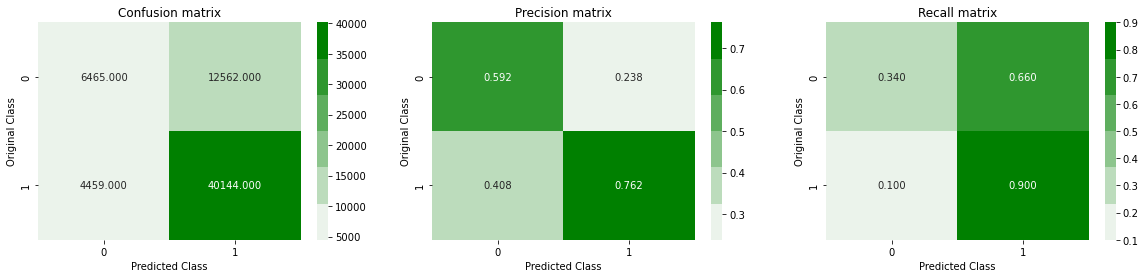

In [64]:
logisticR=LogisticRegression(C=100 ,penalty='l2',class_weight='balanced',n_jobs=-1)
logisticR.fit(X_tr_1,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_tr_1, y_train)

    
model_metrics(sig_clf,X_tr_1,X_te_1,X_cv_1)

plot_confusion_matrix(y_test, sig_clf.predict(X_te_1))

### Linear Support Vector Classification 

In [57]:
param= {'C':[0.001,1,10,100]}

linSVC=LinearSVC(penalty='l2',loss='hinge')

random_svc = RandomizedSearchCV(linSVC,param_distributions=param,scoring='f1',verbose=1,n_jobs=-1,cv=3)
random_svc.fit(X_tr_1,y_train)

print(random_svc.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'C': 0.001}


**LogLoss**
The train log loss is: 0.557698691376337
The cross validation log loss is: 0.5576952722855745
The test log loss is: 0.5584827037401967
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.7161180443965476
The cross validation Accuracy is: 0.7184391908578613
The test Accuracy is: 0.7148829168631149
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.8226546204293125
The cross validation F1 score is: 0.823884621325956
The test F1 score is: 0.8218298240100566
--------------------------------------------------
**AUC**
The train AUC is: 0.5661233666948965
The cross validation AUC is: 0.5698474981417271
The test AUC is: 0.5648754511754378
--------------------------------------------------
Number of misclassified points  28.511708313688512


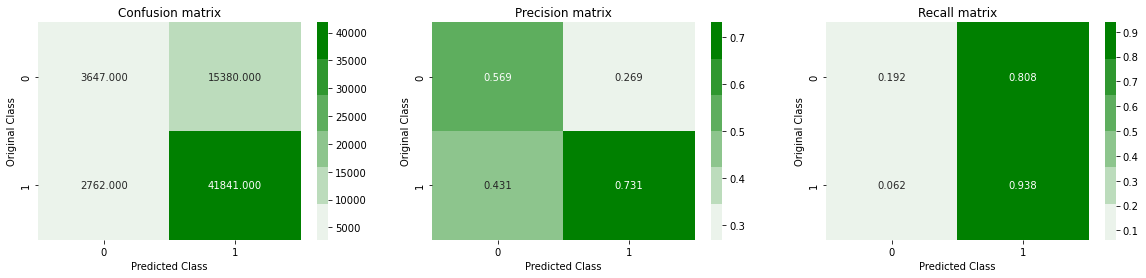

In [65]:
linSVC=LinearSVC(C=0.001 ,penalty='l2',loss='hinge')
linSVC.fit(X_tr_1,y_train)
sig_clf = CalibratedClassifierCV(linSVC, method="sigmoid")
sig_clf.fit(X_tr_1, y_train)

    
model_metrics(sig_clf,X_tr_1,X_te_1,X_cv_1)

plot_confusion_matrix(y_test, sig_clf.predict(X_te_1))

### Random Forest Classifier 

In [62]:
param = {'n_estimators':[100,500,1000,2000,3000]}

rf_clf =RandomForestClassifier(random_state=42,n_jobs=-1)

random_rf = RandomizedSearchCV(rf_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_rf.fit(X_tr_1,y_train)

print(random_rf.best_params_)

{'n_estimators': 3000}


**LogLoss**
The train log loss is: 0.08729853768892455
The cross validation log loss is: 0.3514568306806599
The test log loss is: 0.3546060199769665
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.8513279899418513
The test Accuracy is: 0.8497721200691498
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.8968214397008413
The test F1 score is: 0.8960808827526227
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.8039957985101105
The test AUC is: 0.7998863359244028
--------------------------------------------------
Number of misclassified points  15.022787993085023


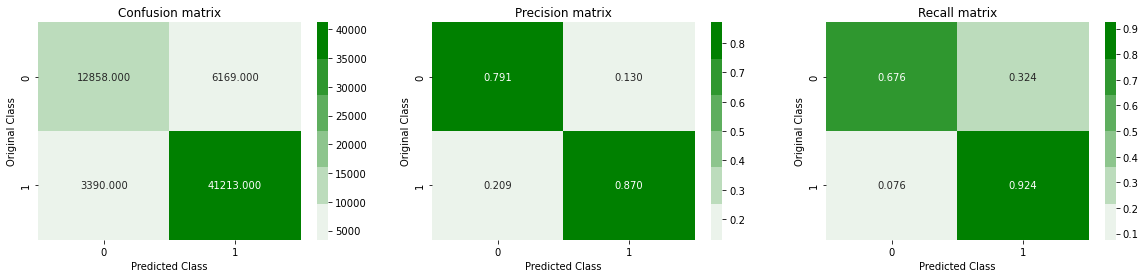

In [31]:
rf_clf =RandomForestClassifier(n_estimators=3000 ,random_state=42,n_jobs=-1)
rf_clf.fit(X_tr_1,y_train)
sig_clf = CalibratedClassifierCV(rf_clf, method="sigmoid")
sig_clf.fit(X_tr_1, y_train)

    
model_metrics(sig_clf,X_tr_1,X_te_1,X_cv_1)

plot_confusion_matrix(y_test, sig_clf.predict(X_te_1))

### XGBOOST Classifier

In [69]:
param = {'n_estimators':[100,500,1000,2000,3000]}
 
x_clf =XGBClassifier(nthread=-1,eval_metric='logloss',objective='binary:logistic', random_state=0)

random_xgb = RandomizedSearchCV(x_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_xgb.fit(X_tr_1,y_train)

print(random_xgb.best_params_)

{'n_estimators': 3000}


**LogLoss**
The train log loss is: 0.16134332769341642
The cross validation log loss is: 0.386258513738559
The test log loss is: 0.3868214872748753
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.848903257672706
The test Accuracy is: 0.8490334747760491
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.8965283970357616
The test F1 score is: 0.8967629610523601
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.791826135425991
The test AUC is: 0.7909964823763416
--------------------------------------------------


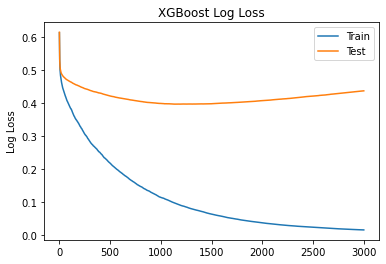

Number of misclassified points  15.096652522395097


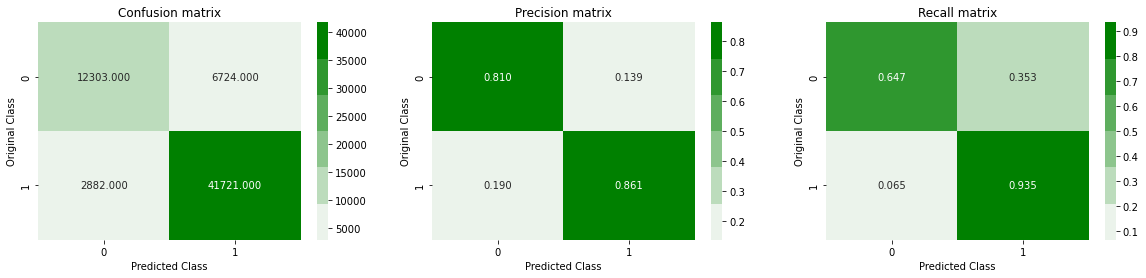

In [71]:
#https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

eval_set = [(X_tr_1, y_train), (X_te_1, y_test)]

x_clf =XGBClassifier(n_estimators=3000,nthread=-1,eval_metric='logloss',objective='binary:logistic',random_state=0)
x_clf.fit(X_tr_1,y_train,eval_set=eval_set,verbose=0)
sig_clf = CalibratedClassifierCV(x_clf, method="sigmoid")
sig_clf.fit(X_tr_1, y_train)

    
model_metrics(sig_clf,X_tr_1,X_te_1,X_cv_1)

results = x_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, sig_clf.predict(X_te_1))

<b> Observations:</b>
- For all the numerical features, the Random Forest and XGB Classifiers works well but both of them are observed to be overfitting. We need to tune the hyperparameters to avoid overfitting in later stages.
- Using Random Forest classifier, the important numerical features can be selected for further modelling. 

In [32]:
columns = ['usefulCount', 'sentiment_score', 'sentiment_score_clean', 'word_count',
       'unique_word_count', 'char_length', 'count_punctuations',
       'stopword_count', 'mean_word_len', 'subj_count', 'obj_count',
       'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC',
       'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT',
       'QUANTITY', 'TIME', 'WORK_OF_ART', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19']

In [33]:
# https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/
# https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

from sklearn.feature_selection import SelectFromModel

def feature_selection_RF(classifier,train_data):
    
    '''this function takes classifier and data as input and returns the columns/features need to be dropped'''
    
    model = SelectFromModel(classifier,prefit=True)

    X_new = model.transform(train_data)
    
    print('Important features count from RF feature importance are:',X_new.shape)
    
    idx = list(model.get_support())
    col= np.array(columns)
    imp_col = col[idx]
    all_col = columns
    drop_col=[]
    for i in all_col:
        if i not in imp_col:
            drop_col.append(i)
    print('Count of features to be dropped:',len(drop_col))
 
    return drop_col
    

In [35]:
drop_col = feature_selection_RF(rf_clf,X_tr_1) # feature selection using RF feature importances

Important features count from RF feature importance are: (103927, 29)
Count of features to be dropped: 20


In [36]:
drop_col

['subj_count',
 'obj_count',
 'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 '9',
 '14']

- From Random Forest feature selection, 20 features can be dropped from our dataset and consider the 29 features for next step of modelling 

In [20]:
drop_col = ['subj_count', 'obj_count', 'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY',
 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', '9', '14']

In [21]:
X_train = X_train.drop(drop_col,axis=1)
X_test = X_test.drop(drop_col,axis=1)
X_cv = X_cv.drop(drop_col,axis=1)

print("After dropping the columns the new shapes are:")
print('Train data size:',X_train.shape)
print('Test data size:',X_test.shape)
print('CV data size:',X_cv.shape)

After dropping the columns the new shapes are:
Train data size: (103927, 33)
Test data size: (63630, 33)
CV data size: (44541, 33)


In [22]:
X_train.columns

Index(['drugName', 'condition', 'usefulCount', 'cleaned_review',
       'sentiment_score', 'sentiment_score_clean', 'year', 'word_count',
       'unique_word_count', 'char_length', 'count_punctuations',
       'stopword_count', 'mean_word_len', 'TIME', 'WORK_OF_ART', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '15', '16', '17',
       '18', '19'],
      dtype='object')

In [23]:
imp_columns = ['usefulCount','word_count', 'unique_word_count', 'char_length', 'count_punctuations',
       'stopword_count', 'mean_word_len', 'TIME', 'WORK_OF_ART', '0', '1', '2',
               '3', '4', '5', '6', '7', '8', '10', '11', '12', '13', '15', '16', '17', '18', '19']


In [24]:
# Normalizing the features after dropping the unimportant features 

normalizer = Normalizer()

X_train_num_2 = normalizer.fit_transform(X_train[imp_columns])
X_test_num_2 = normalizer.fit_transform(X_test[imp_columns])
X_cv_num_2 = normalizer.fit_transform(X_cv[imp_columns])

print("After vectorizations")
print(X_train_num_2.shape, y_train.shape)
print(X_test_num_2.shape, y_test.shape)
print(X_cv_num_2.shape, y_cv.shape)


After vectorizations
(103927, 27) (103927,)
(63630, 27) (63630,)
(44541, 27) (44541,)


### Set - 1 : Important Numerical Features + Sentiment Scores 

In [25]:
#concatenating all encoded features for set 1 

from scipy.sparse import hstack
X_tr_1 = np.concatenate((X_train_num_2,X_train_sent_score),axis=1)

X_te_1 = np.concatenate((X_test_num_2,X_test_sent_score),axis=1)

X_cv_1 = np.concatenate((X_cv_num_2,X_cv_sent_score),axis=1)

print("Final Data matrix")
print(X_tr_1.shape, y_train.shape)
print(X_te_1.shape, y_test.shape)
print(X_cv_1.shape, y_cv.shape)

Final Data matrix
(103927, 29) (103927,)
(63630, 29) (63630,)
(44541, 29) (44541,)


#### HyperParameter Tuning on XGBClassifier 

In [45]:
x_cfl_1 = XGBClassifier()
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,500,1000,2000,3000],
'max_depth':[3,5,7,10,30,50],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1]
}
x_random_cfl_1 = RandomizedSearchCV(x_cfl_1,param_distributions=prams,verbose=0,n_jobs=-1,cv=3,scoring='f1')
x_random_cfl_1.fit(X_tr_1,y_train)

print(x_random_cfl_1.best_params_)
print(x_random_cfl_1.best_score_)

{'subsample': 1, 'n_estimators': 3000, 'max_depth': 30, 'learning_rate': 0.2, 'colsample_bytree': 0.5}
0.87211567222413


#### Training the XGB Classifier with Best parameters 

**LogLoss**
The train log loss is: 0.16973691196047744
The cross validation log loss is: 0.3979638611517696
The test log loss is: 0.39982343354047983
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.8476010866392761
The test Accuracy is: 0.8466760961810467
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.8959278793082301
The test F1 score is: 0.8954856126668523
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.7883141823491899
The test AUC is: 0.7859396509925142
--------------------------------------------------


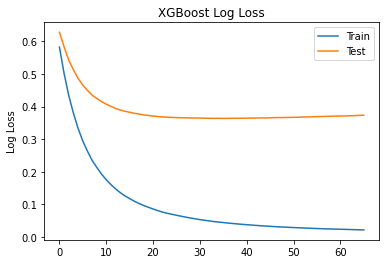

Number of misclassified points  15.332390381895333


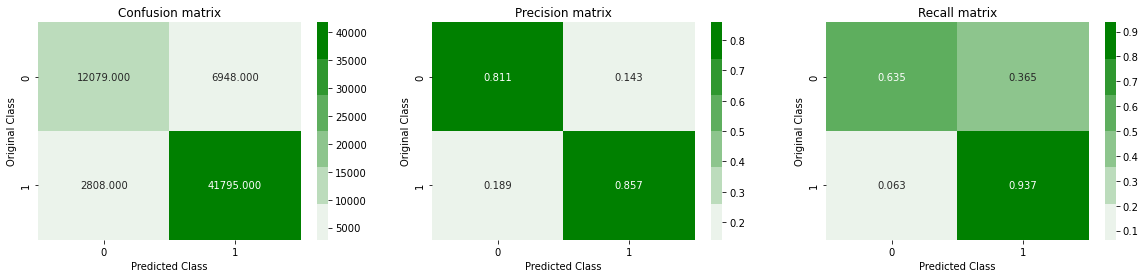

In [68]:
# Here early stopping parameter has been used as in the above xgboost model there is an overfitting 
# occured with same 3000 estimators


eval_set = [(X_tr_1, y_train), (X_cv_1, y_cv)]

x_cfl_1=XGBClassifier(n_estimators=3000,subsample=1,max_depth=30,learning_rate=0.2,colsample_bytree=0.5,nthread=-1,objective='binary:logistic', random_state=0)
x_cfl_1.fit(X_tr_1,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0,early_stopping_rounds=30)
x_sig_clf_1 = CalibratedClassifierCV(x_cfl_1, method="sigmoid")
x_sig_clf_1.fit(X_tr_1, y_train)
    
model_metrics(x_sig_clf_1,X_tr_1,X_te_1,X_cv_1)

results = x_cfl_1.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, x_sig_clf_1.predict(X_te_1))

In [76]:
import joblib

In [77]:
print('Extracted features Model saved..')

joblib.dump(x_sig_clf_1, 'extracted_model.pkl')

Extracted features Model saved..


['extracted_model.pkl']

<b>Observations:
- The XGB classifier with hyper parameter tuning performs well on Set 1 features with log loss of 0.3998 and F1 scoe of 0.895
- This model is saved for Set 1 features

### Set -2 Extracted Features + Sentiment Scores + Reviews Bow (uni-gram) vectors 

In [26]:
#concatenating all encoded features for set 2

from scipy.sparse import hstack
X_tr_2 = hstack((X_train_num_2,X_train_sent_score,X_train_condition,X_train_year,X_train_review_bow_1)).tocsr()

X_te_2 = hstack((X_test_num_2,X_test_sent_score,X_test_condition,X_test_year,X_test_review_bow_1)).tocsr()

X_cv_2 = hstack((X_cv_num_2,X_cv_sent_score,X_cv_condition,X_cv_year,X_cv_review_bow_1)).tocsr()

print("Final Data matrix")
print(X_tr_2.shape, y_train.shape)
print(X_te_2.shape, y_test.shape)
print(X_cv_2.shape, y_cv.shape)

Final Data matrix
(103927, 7340) (103927,)
(63630, 7340) (63630,)
(44541, 7340) (44541,)


#### Random Forest Classifier on Set 2 Features 

In [79]:
param = {'n_estimators':[100,500,1000,2000,3000]}

rf_clf =RandomForestClassifier(random_state=42,n_jobs=-1)

random_rf = RandomizedSearchCV(rf_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_rf.fit(X_tr_2,y_train)

print(random_rf.best_params_)

{'n_estimators': 3000}


**LogLoss**
The train log loss is: 0.051807514052186934
The cross validation log loss is: 0.27750072434068773
The test log loss is: 0.2817033480741443
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.8873397543836016
The test Accuracy is: 0.8844884488448845
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.9999931364406954
The cross validation F1 score is: 0.92159375
The test F1 score is: 0.9197037231253278
--------------------------------------------------
**AUC**
The train AUC is: 0.9999931364878035
The cross validation AUC is: 0.848884012343248
The test AUC is: 0.8446751985142116
--------------------------------------------------
Number of misclassified points  11.55115511551155


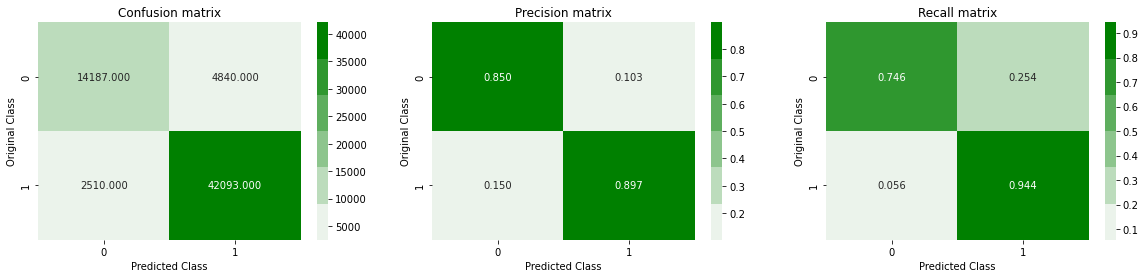

In [24]:
rf_clf =RandomForestClassifier(n_estimators=3000 ,random_state=42,n_jobs=-1)
rf_clf.fit(X_tr_2,y_train)
sig_clf = CalibratedClassifierCV(rf_clf, method="sigmoid")
sig_clf.fit(X_tr_2, y_train)

    
model_metrics(sig_clf,X_tr_2,X_te_2,X_cv_2)

plot_confusion_matrix(y_test, sig_clf.predict(X_te_2))

In [24]:
param = {'n_estimators':[100,500,1000,2000,3000]}
 
x_clf =XGBClassifier(nthread=-1,eval_metric='logloss',objective='binary:logistic', random_state=0)

random_xgb = RandomizedSearchCV(x_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_xgb.fit(X_tr_2,y_train)

print(random_xgb.best_params_)

{'n_estimators': 3000}


**LogLoss**
The train log loss is: 0.09667332134681694
The cross validation log loss is: 0.27192230818690677
The test log loss is: 0.2741442083385732
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.9022473675939022
The test Accuracy is: 0.9011315417256012
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.9317554858934168
The test F1 score is: 0.9310371287942735
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.8688167750192451
The test AUC is: 0.866883545851316
--------------------------------------------------


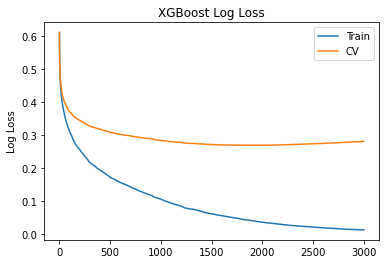

Number of misclassified points  9.886845827439886


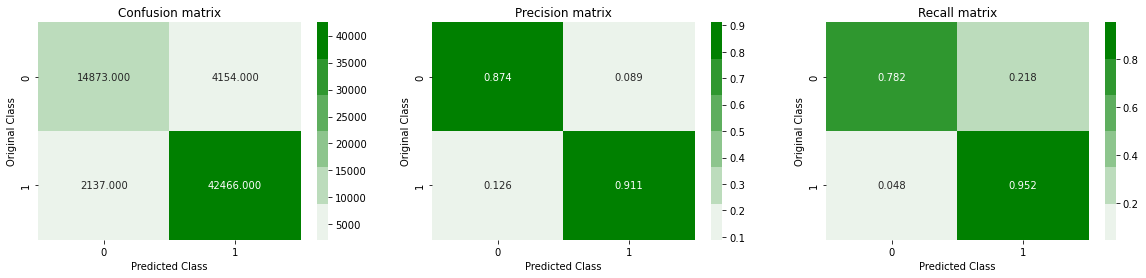

In [25]:
#https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

eval_set = [(X_tr_2, y_train), (X_cv_2, y_cv)]

x_clf =XGBClassifier(n_estimators=3000,nthread=-1,objective='binary:logistic',random_state=0)
x_clf.fit(X_tr_2,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0)
sig_clf = CalibratedClassifierCV(x_clf, method="sigmoid")
sig_clf.fit(X_tr_2, y_train)

    
model_metrics(sig_clf,X_tr_2,X_te_2,X_cv_2)

results = x_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, sig_clf.predict(X_te_2))

#### HyperParameter Tuning on XGBClassifier

In [26]:
x_cfl_2 = XGBClassifier()
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,500,1000,2000,3000],
'max_depth':[3,5,7,10],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1]
}
x_random_cfl_2 = RandomizedSearchCV(x_cfl_2,param_distributions=prams,verbose=0,n_jobs=-1,cv=3,scoring='f1')
x_random_cfl_2.fit(X_tr_2,y_train)

print(x_random_cfl_2.best_params_)

{'subsample': 1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.1}


#### Training XGBClassifier with best parameters

**LogLoss**
The train log loss is: 0.10986655691665105
The cross validation log loss is: 0.27624366744724205
The test log loss is: 0.27872337775566325
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9858843226495521
The cross validation Accuracy is: 0.8949956220111807
The test Accuracy is: 0.8926292629262926
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.989957488756084
The cross validation F1 score is: 0.9266847459752638
The test F1 score is: 0.9251041438281079
--------------------------------------------------
**AUC**
The train AUC is: 0.9814072913958877
The cross validation AUC is: 0.8602430312284636
The test AUC is: 0.8567655215084569
--------------------------------------------------


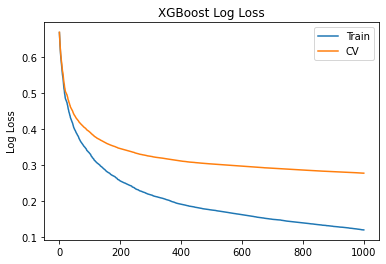

Number of misclassified points  10.737073707370737


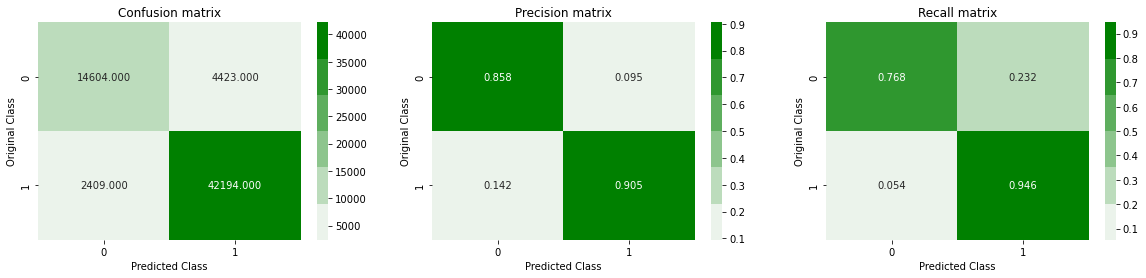

In [27]:
eval_set = [(X_tr_2, y_train), (X_cv_2, y_cv)]

x_cfl_2=XGBClassifier(n_estimators=1000,subsample=1,max_depth=10,learning_rate=0.1,colsample_bytree=0.1,nthread=-1,objective='binary:logistic', random_state=0)
x_cfl_2.fit(X_tr_2,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0,early_stopping_rounds=20)
x_sig_clf_2 = CalibratedClassifierCV(x_cfl_2, method="sigmoid")
x_sig_clf_2.fit(X_tr_2, y_train)
    
model_metrics(x_sig_clf_2,X_tr_2,X_te_2,X_cv_2)

results = x_cfl_2.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, x_sig_clf_2.predict(X_te_2))

In [28]:
import joblib
print('BoW Model saved..')
joblib.dump(x_sig_clf_2, 'Bow_model.pkl')

BoW Model saved..


['Bow_model.pkl']

<b>Observations:
- The XGB classifier with hyper parameter tuning gives log loss of 0.278 and F1 score of 0.925  for set 2 features
- For Bow representation, this model is saved.

### Set -3 Extracted Features + Sentiment Scores + Reviews TF-IDF (uni-gram) vectors 

In [27]:
#concatenating all encoded features for set 3

from scipy.sparse import hstack
X_tr_3 = hstack((X_train_num_2,X_train_sent_score,X_train_condition,X_train_year,X_train_review_tfidf_1)).tocsr()

X_te_3 = hstack((X_test_num_2,X_test_sent_score,X_test_condition,X_test_year,X_test_review_tfidf_1)).tocsr()

X_cv_3 = hstack((X_cv_num_2,X_cv_sent_score,X_cv_condition,X_cv_year,X_cv_review_tfidf_1)).tocsr()

print("Final Data matrix")
print(X_tr_3.shape, y_train.shape)
print(X_te_3.shape, y_test.shape)
print(X_cv_3.shape, y_cv.shape)



Final Data matrix
(103927, 7340) (103927,)
(63630, 7340) (63630,)
(44541, 7340) (44541,)


#### XGB Classifier on Set 3 Features 

In [30]:
param = {'n_estimators':[100,500,1000,2000,3000]}
 
x_clf =XGBClassifier(nthread=-1,eval_metric='logloss',objective='binary:logistic', random_state=0)

random_xgb = RandomizedSearchCV(x_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_xgb.fit(X_tr_3,y_train)

print(random_xgb.best_params_)

{'n_estimators': 3000}


**LogLoss**
The train log loss is: 0.09586619975883244
The cross validation log loss is: 0.2745412179503166
The test log loss is: 0.27723192434765137
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.9003839159426147
The test Accuracy is: 0.8992613547068993
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.930473071438645
The test F1 score is: 0.9297380247725527
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.8664112837128496
The test AUC is: 0.8646002432624235
--------------------------------------------------


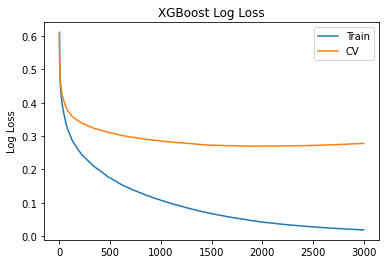

Number of misclassified points  10.073864529310073


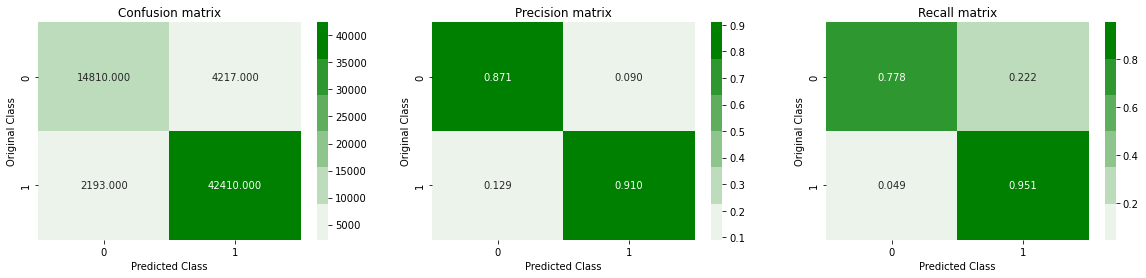

In [32]:
#https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

eval_set = [(X_tr_3, y_train), (X_cv_3, y_cv)]

x_clf =XGBClassifier(n_estimators=3000,nthread=-1,objective='binary:logistic',random_state=0)
x_clf.fit(X_tr_3,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0)
sig_clf = CalibratedClassifierCV(x_clf, method="sigmoid")
sig_clf.fit(X_tr_3, y_train)

    
model_metrics(sig_clf,X_tr_3,X_te_3,X_cv_3)

results = x_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, sig_clf.predict(X_te_3))

#### Hyperparameter Tuning for XGB Classifier  

In [33]:
x_cfl_3 = XGBClassifier()
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,500,1000,2000,3000],
'max_depth':[3,5,7,10],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1]
}
x_random_cfl_3 = RandomizedSearchCV(x_cfl_3,param_distributions=prams,verbose=0,n_jobs=-1,cv=3,scoring='f1')
x_random_cfl_3.fit(X_tr_3,y_train)

print(x_random_cfl_3.best_params_)

{'subsample': 0.3, 'n_estimators': 3000, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1}


#### Training the XGB Classifier with best parameters 

**LogLoss**
The train log loss is: 0.13642934082172956
The cross validation log loss is: 0.29110102101757857
The test log loss is: 0.2939989744759496
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9730291454578694
The cross validation Accuracy is: 0.8853191441593139
The test Accuracy is: 0.883969825553984
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.9808617993868676
The cross validation F1 score is: 0.9199448327743472
The test F1 score is: 0.9190717863837157
--------------------------------------------------
**AUC**
The train AUC is: 0.9643133304368862
The cross validation AUC is: 0.848562073311508
The test AUC is: 0.8463696442632924
--------------------------------------------------


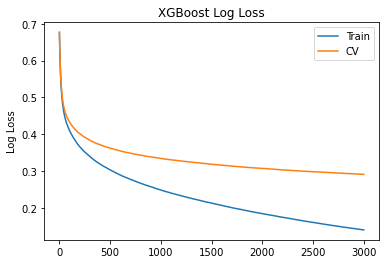

Number of misclassified points  11.603017444601603


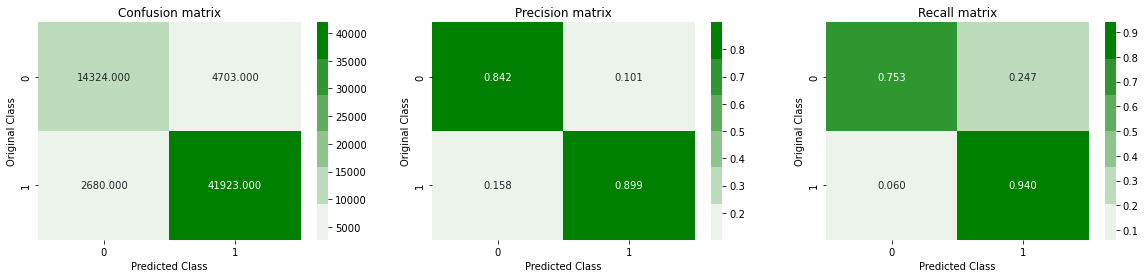

In [23]:
eval_set = [(X_tr_3, y_train), (X_cv_3, y_cv)]

x_cfl_3=XGBClassifier(n_estimators=3000,subsample=0.3,max_depth=7,learning_rate=0.05,colsample_bytree=1,nthread=-1,objective='binary:logistic', random_state=0)
x_cfl_3.fit(X_tr_3,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0,early_stopping_rounds=30)
x_sig_clf_3 = CalibratedClassifierCV(x_cfl_3, method="sigmoid")
x_sig_clf_3.fit(X_tr_3, y_train)
    
model_metrics(x_sig_clf_3,X_tr_3,X_te_3,X_cv_3)

results = x_cfl_3.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, x_sig_clf_3.predict(X_te_3))

In [24]:
print('TF-IDF Model saved..')
joblib.dump(x_sig_clf_3, 'tfidf_model.pkl')


TF-IDF Model saved..


['tfidf_model.pkl']

<b> Observations:
- The XGB Classifier with hyper parameter tuning performs well on Set 3 Features with log loss of 0.293 and F1 score of 0.9190 
- This model is saved for Set 3 Features 

### Set -4 Extracted Features + Sentiment Scores + Reviews BoW (n-gram) vectors 

- Based on onbservation of some words like 'absolut no side effect', 'no side effect', 'almost no side effect', 'great no pain'. Considering the 2,3,4 grams and vocabulary as words with only no exists in it. 

In [33]:
ngram_vec_bow = CountVectorizer(min_df=10,ngram_range=(2,4))
ngram_vec_bow.fit(X_train['cleaned_review'].values)

CountVectorizer(min_df=10, ngram_range=(2, 4))

In [42]:
# Selecting the ngrams if only 'no' exists in it.

vocab = []
for i in ngram_vec_bow.get_feature_names_out():
    if 'no' in i.split(' '):
        vocab.append(i)
print('The Vocab size with only "no" in words is',len(vocab))
print(50*'-')
ngram_vec_bow = CountVectorizer(ngram_range=(2,4),vocabulary=vocab)
print('New vectorizer vocab size:',ngram_vec_bow.get_feature_names_out().shape[0])
print('Saving the new vectorizer with above selected vocabulary..')
joblib.dump(ngram_vec_bow,'ngram_vec_bow.pkl')

The Vocab size with only "no" in words is 2283
--------------------------------------------------
New vectorizer vocab size: 2283
Saving the new vectorizer with above selected vocabulary..


['ngram_vec_bow.pkl']

In [28]:
vec_bow = joblib.load('ngram_vec_bow.pkl')

X_train_review_bow_ngram = vec_bow.transform(X_train['cleaned_review'].values)
X_test_review_bow_ngram = vec_bow.transform(X_test['cleaned_review'].values)
X_cv_review_bow_ngram = vec_bow.transform(X_cv['cleaned_review'].values)


print('After Vectorization')
print('Train data shape:',X_train_review_bow_ngram.shape)
print('Test data shape:',X_test_review_bow_ngram.shape)
print('CV data shape:',X_cv_review_bow_ngram.shape)

After Vectorization
Train data shape: (103927, 2283)
Test data shape: (63630, 2283)
CV data shape: (44541, 2283)


In [29]:
#concatenating all encoded features for set 4

from scipy.sparse import hstack
X_tr_4 = hstack((X_train_num_2,X_train_sent_score,X_train_condition,X_train_year,X_train_review_bow_ngram)).tocsr()

X_te_4 = hstack((X_test_num_2,X_test_sent_score,X_test_condition,X_test_year,X_test_review_bow_ngram)).tocsr()

X_cv_4 = hstack((X_cv_num_2,X_cv_sent_score,X_cv_condition,X_cv_year,X_cv_review_bow_ngram)).tocsr()

print("Final Data matrix")
print(X_tr_4.shape, y_train.shape)
print(X_te_4.shape, y_test.shape)
print(X_cv_4.shape, y_cv.shape)


Final Data matrix
(103927, 2314) (103927,)
(63630, 2314) (63630,)
(44541, 2314) (44541,)


#### XGB Classifier on Set 4 Features 

In [52]:
param = {'n_estimators':[100,500,1000,2000,3000]}
 
x_clf =XGBClassifier(nthread=-1,eval_metric='logloss',objective='binary:logistic', random_state=0)

random_xgb = RandomizedSearchCV(x_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_xgb.fit(X_tr_4,y_train)

print(random_xgb.best_params_)

{'n_estimators': 2000}


**LogLoss**
The train log loss is: 0.1370362406024604
The cross validation log loss is: 0.34752482807489854
The test log loss is: 0.3497392909981514
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999134007524513
The cross validation Accuracy is: 0.8684807256235828
The test Accuracy is: 0.8663209178060663
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999938232205728
The cross validation F1 score is: 0.909155759568265
The test F1 score is: 0.9076217989096201
--------------------------------------------------
**AUC**
The train AUC is: 0.9998552030375185
The cross validation AUC is: 0.8211817426525136
The test AUC is: 0.8189233249584293
--------------------------------------------------


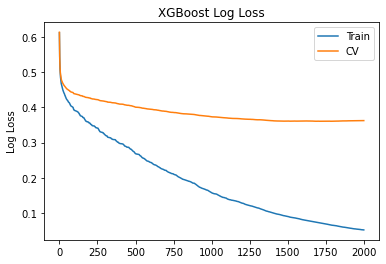

Number of misclassified points  13.367908219393367


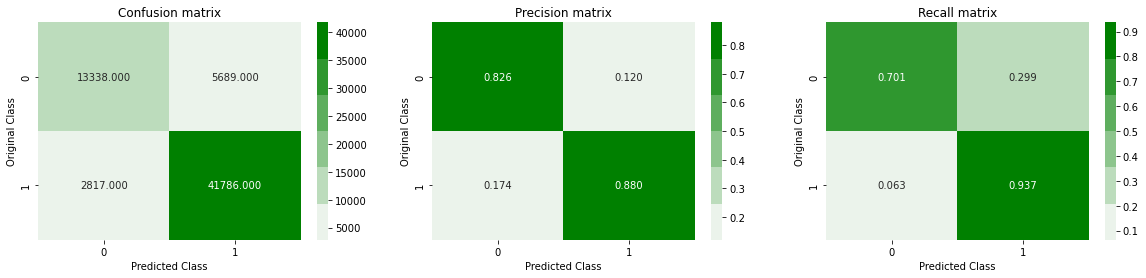

In [53]:
#https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

eval_set = [(X_tr_4, y_train), (X_cv_4, y_cv)]

x_clf =XGBClassifier(n_estimators=2000,nthread=-1,objective='binary:logistic',random_state=0)
x_clf.fit(X_tr_4,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0)
sig_clf = CalibratedClassifierCV(x_clf, method="sigmoid")
sig_clf.fit(X_tr_4, y_train)

    
model_metrics(sig_clf,X_tr_4,X_te_4,X_cv_4)

results = x_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, sig_clf.predict(X_te_4))

#### Hyperparameter Tuning for XGB Classifier  

In [54]:
x_cfl_4 = XGBClassifier()
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,500,1000,2000,3000],
'max_depth':[3,5,7,10],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1]
}
x_random_cfl_4 = RandomizedSearchCV(x_cfl_4,param_distributions=prams,verbose=0,n_jobs=-1,cv=3,scoring='f1')
x_random_cfl_4.fit(X_tr_4,y_train)

print(x_random_cfl_4.best_params_)

{'subsample': 0.5, 'n_estimators': 3000, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.3}


**LogLoss**
The train log loss is: 0.12498534625180444
The cross validation log loss is: 0.34407672769840747
The test log loss is: 0.3461873989687194
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9980274615836116
The cross validation Accuracy is: 0.8657416762084371
The test Accuracy is: 0.8652836712242653
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.9985939739782306
The cross validation F1 score is: 0.9069347609561753
The test F1 score is: 0.9065579488968345
--------------------------------------------------
**AUC**
The train AUC is: 0.9971723239644084
The cross validation AUC is: 0.8203688704643893
The test AUC is: 0.8202629088718849
--------------------------------------------------


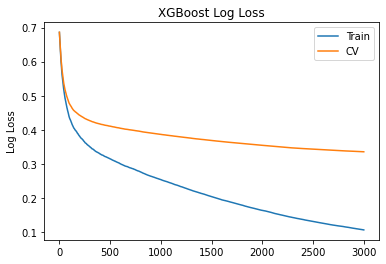

Number of misclassified points  13.471632877573473


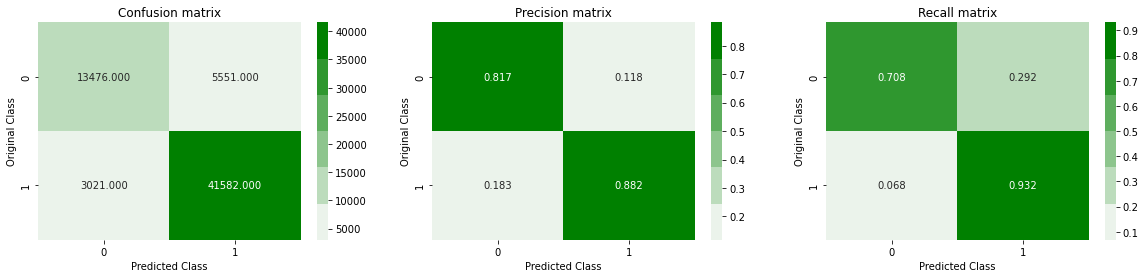

In [55]:
eval_set = [(X_tr_4, y_train), (X_cv_4, y_cv)]

x_cfl_4=XGBClassifier(n_estimators=3000,subsample=0.5,max_depth=10,learning_rate=0.03,colsample_bytree=0.3,nthread=-1,objective='binary:logistic', random_state=0)
x_cfl_4.fit(X_tr_4,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0,early_stopping_rounds=30)
x_sig_clf_4 = CalibratedClassifierCV(x_cfl_4, method="sigmoid")
x_sig_clf_4.fit(X_tr_4, y_train)
    
model_metrics(x_sig_clf_4,X_tr_4,X_te_4,X_cv_4)

results = x_cfl_4.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, x_sig_clf_4.predict(X_te_4))

In [56]:
print('Ngram Bow Model saved')
joblib.dump(x_sig_clf_4,'ngram_bow_model.pkl')

Ngram Bow Model saved


['ngram_bow_model.pkl']

### Set -5 Extracted Features + Sentiment Scores + Reviews TF-IDF (ngram) vectors 

In [97]:
# selecting only 2,3,4 grams to vectorize using tfidf vectorizer.

ngram_vec_tfidf = TfidfVectorizer(ngram_range=(2,4),vocabulary=vocab)
ngram_vec_tfidf.fit(vocab)
print('New vectorizer vocab size:',ngram_vec_tfidf.get_feature_names_out().shape[0])
print('Saving the new vectorizer with above selected vocabulary..')
joblib.dump(ngram_vec_tfidf,'ngram_vec_tfidf.pkl')

New vectorizer vocab size: 2283
Saving the new vectorizer with above selected vocabulary..


['ngram_vec_tfidf.pkl']

In [30]:
vec_tfidf = joblib.load('ngram_vec_tfidf.pkl')

X_train_review_tfidf_ngram = vec_tfidf.transform(X_train['cleaned_review'].values)
X_test_review_tfidf_ngram = vec_tfidf.transform(X_test['cleaned_review'].values)
X_cv_review_tfidf_ngram = vec_tfidf.transform(X_cv['cleaned_review'].values)


print('After Vectorization')
print('Train data shape:',X_train_review_tfidf_ngram.shape)
print('Test data shape:',X_test_review_tfidf_ngram.shape)
print('CV data shape:',X_cv_review_tfidf_ngram.shape)

After Vectorization
Train data shape: (103927, 2283)
Test data shape: (63630, 2283)
CV data shape: (44541, 2283)


In [31]:
#concatenating all encoded features for set 5

from scipy.sparse import hstack
X_tr_5 = hstack((X_train_num_2,X_train_sent_score,X_train_condition,X_train_year,X_train_review_tfidf_ngram)).tocsr()

X_te_5 = hstack((X_test_num_2,X_test_sent_score,X_test_condition,X_test_year,X_test_review_tfidf_ngram)).tocsr()

X_cv_5 = hstack((X_cv_num_2,X_cv_sent_score,X_cv_condition,X_cv_year,X_cv_review_tfidf_ngram)).tocsr()

print("Final Data matrix")
print(X_tr_5.shape, y_train.shape)
print(X_te_5.shape, y_test.shape)
print(X_cv_5.shape, y_cv.shape)


Final Data matrix
(103927, 2314) (103927,)
(63630, 2314) (63630,)
(44541, 2314) (44541,)


#### XGB Classifier on Set 5 Features 

In [113]:
param = {'n_estimators':[100,500,1000,2000,3000]}
 
x_clf =XGBClassifier(nthread=-1,eval_metric='logloss',objective='binary:logistic', random_state=0)

random_xgb = RandomizedSearchCV(x_clf,param_distributions=param,scoring='f1',verbose=0,n_jobs=-1,cv=3)
random_xgb.fit(X_tr_5,y_train)

print(random_xgb.best_params_)

{'n_estimators': 3000}


**LogLoss**
The train log loss is: 0.13814669692271123
The cross validation log loss is: 0.3491388135153498
The test log loss is: 0.35192505293719845
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.8680766035787252
The test Accuracy is: 0.8658651579443659
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.908913346767943
The test F1 score is: 0.9073742471105323
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.8204199122185233
The test AUC is: 0.8178749496879663
--------------------------------------------------


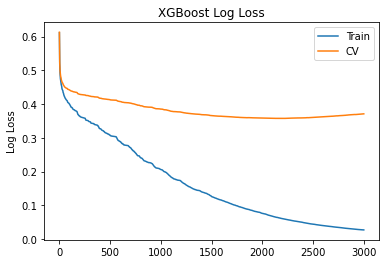

Number of misclassified points  13.413484205563414


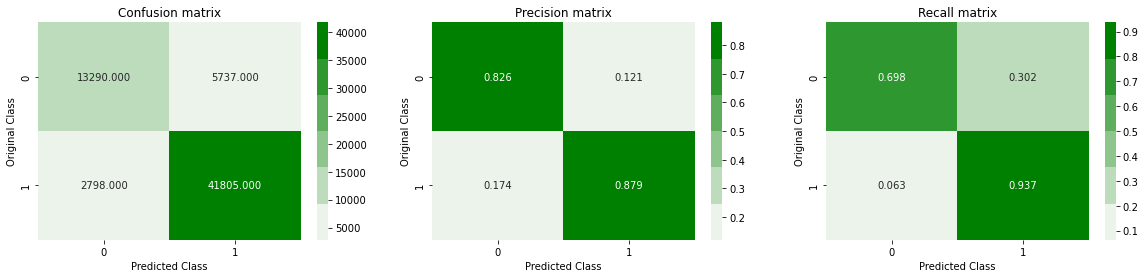

In [114]:
#https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

eval_set = [(X_tr_5, y_train), (X_cv_5, y_cv)]

x_clf =XGBClassifier(n_estimators=3000,nthread=-1,objective='binary:logistic',random_state=0)
x_clf.fit(X_tr_5,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0)
sig_clf = CalibratedClassifierCV(x_clf, method="sigmoid")
sig_clf.fit(X_tr_5, y_train)

    
model_metrics(sig_clf,X_tr_5,X_te_5,X_cv_5)

results = x_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, sig_clf.predict(X_te_5))

#### Hyperparameter Tuning for XGB Classifier  

In [115]:
x_cfl_5 = XGBClassifier()
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,500,1000,2000,3000],
'max_depth':[3,5,7,10],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1]
}
x_random_cfl_5 = RandomizedSearchCV(x_cfl_5,param_distributions=prams,verbose=0,n_jobs=-1,cv=3,scoring='f1')
x_random_cfl_5.fit(X_tr_5,y_train)

print(x_random_cfl_5.best_params_)

{'subsample': 0.5, 'n_estimators': 3000, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.1}


**LogLoss**
The train log loss is: 0.14659202567118915
The cross validation log loss is: 0.3614213290920811
The test log loss is: 0.36373891290894667
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.8624637974001482
The test Accuracy is: 0.8608046518937608
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.9053870389818991
The test F1 score is: 0.9042434726201417
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.8111639792900358
The test AUC is: 0.8092023318075708
--------------------------------------------------


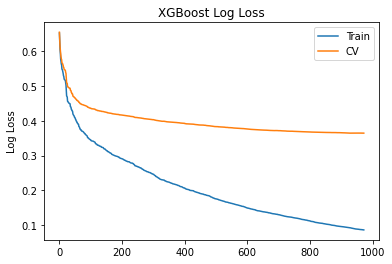

Number of misclassified points  13.91953481062392


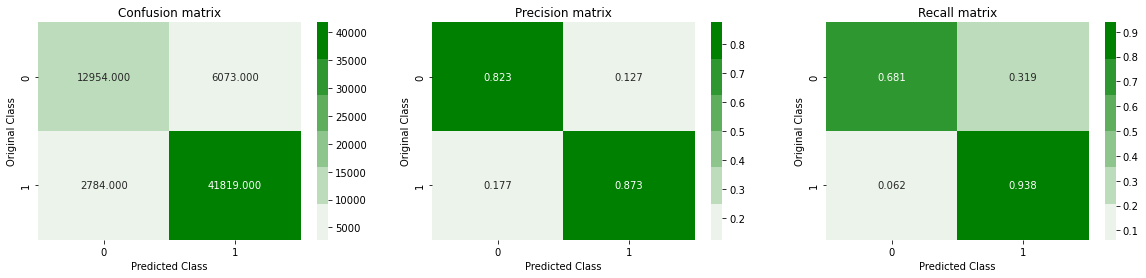

In [116]:
eval_set = [(X_tr_5, y_train), (X_cv_5, y_cv)]

x_cfl_5=XGBClassifier(n_estimators=3000,subsample=0.5,max_depth=10,learning_rate=0.2,colsample_bytree=0.1,nthread=-1,objective='binary:logistic', random_state=0)
x_cfl_5.fit(X_tr_5,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0,early_stopping_rounds=30)
x_sig_clf_5 = CalibratedClassifierCV(x_cfl_5, method="sigmoid")
x_sig_clf_5.fit(X_tr_5, y_train)
    
model_metrics(x_sig_clf_5,X_tr_5,X_te_5,X_cv_5)

results = x_cfl_5.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, x_sig_clf_5.predict(X_te_5))

In [117]:
print('Ngram TFIDF Model saved')
joblib.dump(x_sig_clf_5,'ngram_tfidf_model.pkl')

Ngram TFIDF Model saved


['ngram_tfidf_model.pkl']

<b>Observations:</b>
- The n-grams (both Bow and TF-IDF) has also performed good with only considerable features. Hence considering unigram and n-gram(2,3,4) feature set models for both BoW and TF-IDF. 

#### Building the Word2Vec embeddings for the words in our dataset using Gensim

In [32]:
from gensim.models import Word2Vec

In [13]:
sentences = []
for r in tqdm(data['cleaned_review']):
    sentences.append(r.split())

100%|██████████████████████████████████████████████████████████████| 212098/212098 [00:01<00:00, 128082.18it/s]


In [41]:
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# https://radimrehurek.com/gensim/models/word2vec.html

model = Word2Vec(sentences,vector_size=300,workers=12,min_count=1)
print(model)
model.save('word2vec.bin')


Word2Vec<vocab=34666, vector_size=300, alpha=0.025>


In [33]:
model = Word2Vec.load('word2vec.bin')

In [34]:
def create_w2v(df,feature):
    '''This function creates the w2v embeddings for the cleaned reviews passed'''

    w2v_vector =[]
    for review in df[feature]:
        vector = np.zeros(300)
        
        for word in review.split():
            if word in model.wv.key_to_index:
                vector += model.wv[word]
            
        w2v_vector.append(vector)
    w2v_vector = np.array(w2v_vector)
    return w2v_vector
    
    

In [35]:
X_train_review_w2v = create_w2v(X_train,'cleaned_review')
X_test_review_w2v = create_w2v(X_test,'cleaned_review')
X_cv_review_w2v = create_w2v(X_cv,'cleaned_review')

print('After word embeddings')
print('Train data size is:',X_train_review_w2v.shape)
print('Test data size is:',X_test_review_w2v.shape)
print('CV data size is:',X_cv_review_w2v.shape)

After word embeddings
Train data size is: (103927, 300)
Test data size is: (63630, 300)
CV data size is: (44541, 300)


### Set -6 Extracted Features + Sentiment Scores + Reviews Word2Vec vectors 

In [36]:
#concatenating all encoded features for set 6

from scipy.sparse import hstack
X_tr_6 = np.concatenate((X_train_num_2,X_train_sent_score,X_train_condition,X_train_year,X_train_review_w2v),axis=1)

X_te_6 = np.concatenate((X_test_num_2,X_test_sent_score,X_test_condition,X_test_year,X_test_review_w2v),axis=1)

X_cv_6 = np.concatenate((X_cv_num_2,X_cv_sent_score,X_cv_condition,X_cv_year,X_cv_review_w2v),axis=1)

print("Final Data matrix")
print(X_tr_6.shape, y_train.shape)
print(X_te_6.shape, y_test.shape)
print(X_cv_6.shape, y_cv.shape)



Final Data matrix
(103927, 331) (103927,)
(63630, 331) (63630,)
(44541, 331) (44541,)


#### XGB Classifier on Set 3 Features 

#### Hyperparameter Tuning for XGB Classifier  

In [24]:
x_cfl_6 = XGBClassifier()
prams={
'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
'n_estimators':[100,500,1000,2000,3000],
'max_depth':[3,5,7,10],
'colsample_bytree':[0.1,0.3,0.5,1],
'subsample':[0.1,0.3,0.5,1]
}
x_random_cfl_6 = RandomizedSearchCV(x_cfl_6,param_distributions=prams,verbose=0,n_jobs=-1,cv=3,scoring='f1')
x_random_cfl_6.fit(X_tr_6,y_train)

print(x_random_cfl_6.best_params_)

{'subsample': 1, 'n_estimators': 3000, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1}


#### Training the XGB Classifier with best parameters 

**LogLoss**
The train log loss is: 0.09418137102532786
The cross validation log loss is: 0.28185914782862226
The test log loss is: 0.2866658513584094
--------------------------------------------------
**Accuracy**
The train Accuracy is: 0.9999903778613835
The cross validation Accuracy is: 0.9000920500213286
The test Accuracy is: 0.8974854628319975
--------------------------------------------------
**F1 Score**
The train F1 score is: 0.999993136534911
The cross validation F1 score is: 0.9304361419415351
The test F1 score is: 0.9285878501910382
--------------------------------------------------
**AUC**
The train AUC is: 0.9999839114486131
The cross validation AUC is: 0.8644164385945561
The test AUC is: 0.8616307788171615
--------------------------------------------------


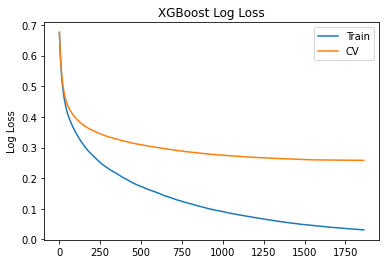

Number of misclassified points  10.251453716800253


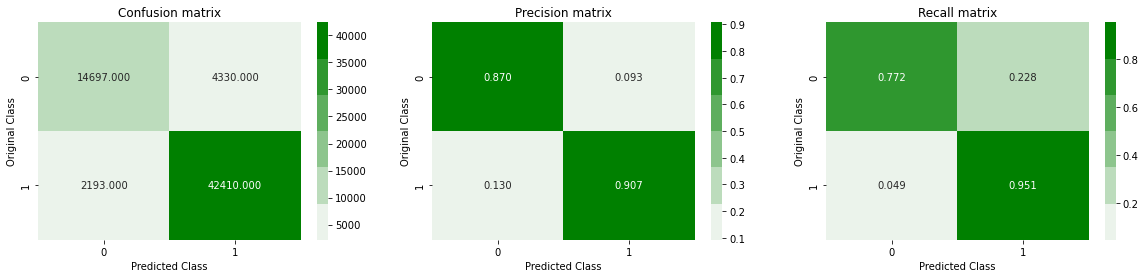

In [25]:
eval_set = [(X_tr_6, y_train), (X_cv_6, y_cv)]

x_cfl_6=XGBClassifier(n_estimators=3000,subsample=1,max_depth=7,learning_rate=0.05,colsample_bytree=1,nthread=-1,objective='binary:logistic', random_state=0)
x_cfl_6.fit(X_tr_6,y_train,eval_set=eval_set,eval_metric='logloss',verbose=0,early_stopping_rounds=30)
x_sig_clf_6 = CalibratedClassifierCV(x_cfl_6, method="sigmoid")
x_sig_clf_6.fit(X_tr_6, y_train)
    
model_metrics(x_sig_clf_6,X_tr_6,X_te_6,X_cv_6)

results = x_cfl_6.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='CV')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


plot_confusion_matrix(y_test, x_sig_clf_6.predict(X_te_6))

In [26]:
import joblib
print('W2V Model saved')
joblib.dump(x_sig_clf_6,'W2V Model.pkl')

W2V Model saved


['W2V Model.pkl']

The W2v embeddings features are also useful. The model has a F1 score of 0.928

### Model Evaluation Metrics summary

In [37]:
from prettytable import PrettyTable

In [38]:
model_1 = joblib.load('extracted_model.pkl')
model_2 = joblib.load('Bow_model.pkl')
model_3 = joblib.load('tfidf_model.pkl')
model_4 = joblib.load('ngram_bow_model.pkl')
model_5 = joblib.load('ngram_tfidf_model.pkl')
model_6 = joblib.load('W2V Model.pkl')

In [38]:
t = PrettyTable()
t.field_names = ['Models','F1 Score(Train Data)','F1 Score(Test Data)']
t.add_row(['XGBOOST+BoW(1gram)',f1_score(y_train,model_2.predict(X_tr_2)),f1_score(y_test,model_2.predict(X_te_2))])
t.add_row(['XGBOOST+TF-IDF(1gram)',f1_score(y_train,model_3.predict(X_tr_3)),f1_score(y_test,model_3.predict(X_te_3))])
t.add_row(['XGBOOST+BoW(n-grams)',f1_score(y_train,model_4.predict(X_tr_4)),f1_score(y_test,model_4.predict(X_te_4))])
t.add_row(['XGBOOST+TFIDF(n-gram)',f1_score(y_train,model_5.predict(X_tr_5)),f1_score(y_test,model_5.predict(X_te_5))])
t.add_row(['XGBOOST+Word2Vec',f1_score(y_train,model_6.predict(X_tr_6)),f1_score(y_test,model_6.predict(X_te_6))])
print(t)

+-----------------------+----------------------+---------------------+
|         Models        | F1 Score(Train Data) | F1 Score(Test Data) |
+-----------------------+----------------------+---------------------+
|   XGBOOST+BoW(1gram)  |  0.989957488756084   |  0.9251041438281079 |
| XGBOOST+TF-IDF(1gram) |  0.9808617993868676  |  0.9190717863837157 |
|  XGBOOST+BoW(n-grams) |  0.9985939739782306  |  0.9065579488968345 |
| XGBOOST+TFIDF(n-gram) |  0.999993136534911   |  0.9042434726201417 |
|    XGBOOST+Word2Vec   |  0.999993136534911   |  0.9285878501910382 |
+-----------------------+----------------------+---------------------+


### Recommendation system 

In [39]:
def userful_count(data,feature):
    '''this function takes dataframe and feature as input and normalize the given feature'''
    
    max_value = data[feature].max()
    min_value = data[feature].min()
    data[feature] = (data[feature] - min_value) / (max_value - min_value)
    return data 

In [41]:
# Each model predictions are stored as one column and recommendation score is calculated by adding predictions 
# of 5 models multiplied by its normalized useful count

X_test['model2'] = model_2.predict(X_te_2)
X_test['model3'] = model_3.predict(X_te_3)
X_test['model4'] = model_4.predict(X_te_4)
X_test['model5'] = model_5.predict(X_te_5)
X_test['model6'] = model_6.predict(X_te_6)

X_test =  userful_count(X_test,'usefulCount') 
#X_test['usefulCount'] = X_test['usefulCount']/X_test['user_size']

X_test['rec_score'] = (X_test['model2']+X_test['model3']+X_test['model4']+X_test['model5']+X_test['model6'])*X_test['usefulCount']

X_test.head()

,drugName,condition,usefulCount,cleaned_review,sentiment_score,sentiment_score_clean,year,word_count,unique_word_count,char_length,...,16,17,18,19,model2,model3,model4,model5,model6,rec_score
133439,coreg,heart failure,0.024787,heart attack june day hospit doctor put coreg ...,0.6808,0.7964,2010,21,19,119,...,0.005698,0.440997,0.011428,0.081610,1,1,1,1,1,0.123935
136010,rizatriptan,migraine,0.013168,suffer migrain sinc year old maxalt migrain me...,-0.7974,-0.7717,2015,40,30,243,...,0.004397,0.391026,0.008818,0.101036,1,1,1,1,1,0.065840
63258,restasis,keratoconjunctivitis sicca,0.027885,yes burn get medic actual solut bandaid proble...,-0.1101,-0.7351,2016,68,51,394,...,0.003992,0.355007,0.008006,0.103246,1,1,1,1,1,0.139427
74865,sertraline,social anxiety disorde,0.009295,think end start take pure desper use horribl f...,-0.9041,-0.0258,2015,70,58,421,...,0.003655,0.430528,0.049516,0.073439,1,1,1,1,1,0.046476
2537,amphetamine / dextroamphetamine,adhd,0.007746,prescrib mg st day could liter feel releas med...,-0.9639,-0.3887,2017,77,68,470,...,0.003371,0.375103,0.016481,0.087180,0,0,0,0,0,0.000000


In [50]:
#X_test.to_csv('validation_data.csv',index=False)

In [44]:
# grouping the datafrom with respect to condition and drugname. 

df = X_test.groupby(['condition','drugName']).agg({'rec_score':['sum']})


In [45]:
df.tail()

rec_score
                                                    sum
condition                drugName                      
yellow fever prophylaxis yellow fever vaccine  0.001549
zen shoulde              aleve                 0.009295
                         diclofenac            0.127808
                         indomethacin          0.046476
                         nabumetone            0.013943

<b> Validation for one condition </b>

In [49]:
X_test[X_test['condition']=='zen shoulde'].sort_values(by=['rec_score'],ascending=False)

,drugName,condition,usefulCount,cleaned_review,sentiment_score,sentiment_score_clean,year,word_count,unique_word_count,char_length,...,16,17,18,19,model2,model3,model4,model5,model6,rec_score
65932,diclofenac,zen shoulde,0.025562,great help,0.7783,0.7783,2009,2,2,11,...,0.007732,0.419924,0.015507,0.088432,1,1,1,1,1,0.127808
78663,indomethacin,zen shoulde,0.009295,work,0.0000,0.0000,2011,1,1,5,...,0.007909,0.406685,0.015861,0.090450,1,1,1,1,1,0.046476
99792,nabumetone,zen shoulde,0.004648,side effect experienc medic reliev shoulder pain,-0.1779,-0.5106,2017,7,7,49,...,0.007099,0.426486,0.014237,0.081186,1,1,0,1,0,0.013943
169409,aleve,zen shoulde,0.004648,littl relief finish pt year still great due is...,0.8976,0.8020,2015,19,18,121,...,0.005994,0.479188,0.012021,0.103143,1,1,0,0,0,0.009295
185560,diclofenac,zen shoulde,0.017041,medic somewhat help stiff pain still present s...,-0.7962,-0.4989,2014,15,14,94,...,0.006100,0.401652,0.012233,0.069760,0,0,0,0,0,0.000000


<b> Observations:</b>
- The drug named 'diclofenac' for condition 'zen shoulde' is present two times. Based on the 5 models prediction and useful count, the recommendation score is calculated. The final score of each drug is calculated by addition of same drugs score for a given condition. Hence for this condition,'diclofenac' this drug is recommended with high score

- Based on some observations like for condition 'birth control' we have total of 11563 entries for different drugs used. And for each drug for ex- 'etonogestrel(1309)','ethinyl estradiol / norethindrone(909)','levonorgestrel(850)' we have many entries. By aggreating the rec_score using 'mean' the score for these highly used drugs gets lowered due to which the lowest rated/used drugs are recommended after aggregation. 
- Hence aggregating using 'sum' is used in which scores of same drugs are added together. 

In [75]:
def recommend(condition):
    '''this function takes the given condition as input and returns the top drugs based on highest rec scores'''
    data = pd.read_csv('validation_data.csv')
    select = data[data['condition']==condition]
    drug_count = select['drugName'].nunique()
    select['rec_score'] = select['rec_score']/drug_count
    group_drug = select.groupby(['drugName']).agg({'rec_score':['sum']})
    group_drug = group_drug[('rec_score', 'sum')].sort_values(ascending=False)
    drug_score = dict(group_drug)
    if len(drug_score)>5:
        print('Top 5 Drugs for the condition : {0}'.format(condition.upper()))
        for i in list(drug_score.keys())[0:5]:
            print('->',i)        
            
    else:
        print('Top  Drugs for the condition : {0}'.format(condition.upper()))
        for i in drug_score.keys():
            print('->',i)
    

In [76]:
recommend('birth control')

Top 5 Drugs for the condition : BIRTH CONTROL
-> etonogestrel
-> ethinyl estradiol / norethindrone
-> levonorgestrel
-> ethinyl estradiol / norgestimate
-> mirena


In [77]:
recommend('zen shoulde')

Top  Drugs for the condition : ZEN SHOULDE
-> diclofenac
-> indomethacin
-> nabumetone
-> aleve
